# Read in training and testing data and do some housekeeping:
1. Remove duplicate rows
2. Split both datasets into an n-dim feature/design matrix and 1-dim target/predictor vector
3. Manually encode a value to the binary categorical labels of the target/predictor vector

In [2]:
import numpy as np
import pandas as pd


# Read in the data, note: 'education-num' is a proxy for number of years in education
dataTypes = {'age':np.uint8,'workclass':'category', 'fnlwgt':np.uint32, 'education':'category', 'education-num':np.uint8,
             'marital-status':'category', 'occupation':'category', 'relationship':'category', 'race':'category', 'sex':'category', 
             'capital-gain':np.uint32, 'capital-loss':np.uint32, 'hours-per-week':np.uint8, 'native-country':'category',
             'class':'category'}


# Note, we have a mixture of categorical and numerical data, 
df_train = pd.read_csv('trainingData/au_train.csv', dtype=dataTypes, skipinitialspace=True, engine='c')
df_test = pd.read_csv('testingData/au_test.csv', dtype=dataTypes, skipinitialspace=True ,engine='c')
# print(df_train.head())
# print(df_test.head())


# Check for duplicate rows
# print(df_train.drop_duplicates(inplace=True))
# print(df_test.drop_duplicates(inplace=True))


# Check some information and for bad values
# print('\nCheck some prelimiary info and for missing values/NaN:')
# print(df_train.info(),df_test.info())
# print(df_train.describe(),df_test.describe())


# Check for unlabeled categorical features in our DataFrames / misspellings
# print(sorted(list(df_train['workclass'].unique())))
# print(sorted(list(df_train['occupation'].unique())))
# print(sorted(list(df_train['native-country'].unique())))
# print(sorted(list(df_test['workclass'].unique())))
# print(sorted(list(df_test['occupation'].unique())))
# print(sorted(list(df_test['native-country'].unique())))


# Check for misspelled labels
categories = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country','class']
for cat in categories:
    a = set(df_train[cat].unique())
    b = set(df_test[cat].unique())
    if len(a.difference(b)):
        print('\nProblem while checking for missing/bad labels:')
        print('Categories in `%s` column of df_train not in df_test:'%cat,a.difference(b))
        print('Categories in `%s` column of df_test not in df_train:'%cat,b.difference(a))
# Note: The test sets target has an extraneous '.' at the end. Handle this manually later
# In addition there is no entry for 'Holand-Netherlands' in the test set so you could argue that data 
# to train on may not be needed
print('\n\n# of entries before dropping Holand-Netherlands:',len(df_train))
# df_train = df_train.replace('Holand-Netherlands',-1)
# print(df_train.query('`native-country` == -1',engine='python'))
df_train = df_train.replace('Holand-Netherlands',np.nan).dropna()
print('# of entries after dropping Holand-Netherlands:',len(df_train))



# Have some unlabeled/missing values (i.e '?') of categorical features in: 
#                'workclass','occupation','native-country'
# in both our training and testing DataFrame (categorical), need to drop those
print('\n\n# of rows in df_train before dropping unlabeled/missing values:',len(df_train))
df_train = df_train.replace('?',np.nan).dropna()
print('# of rows in df_train after dropping unlabeled/missing values:',len(df_train))
print('\n\n# of rows in df_test before dropping unlabeled/missing values:',len(df_test))
df_test = df_test.replace('?',np.nan).dropna()
print('# of rows in df_test after dropping unlabeled/missing values:',len(df_test))


# Split our data into 'X' commonly referred to as the 'Design Matrix' which contains our 
# 'predictors/features' and 'y' containing our prediction labels
y_train = df_train['class'].to_numpy()
X_train = df_train.drop(columns=['class'])

y_test = df_test['class'].to_numpy()
X_test = df_test.drop(columns=['class'])


# Manually encode (easy to do for a 1d array) a numerical value for our predictor which had
# a binary value
#            <=50K  --->    0
#             >50K  --->    1
y_train = np.where(y_train=='>50K',1,0)
y_test = np.where(y_test=='>50K.',1,0)


# Check to see the distribution of the predictors in both sets
print('\n\nTraining predictor has',len(y_train),'samples and',np.sum(y_train),'of those samples \
are classified as >50K')
print('% of training sample >50K:',np.sum(y_train)/len(y_train))
print('% of training sample <=50K:',1-np.sum(y_train)/len(y_train))
print('\n\nTesting predictor has',len(y_test),'samples and',np.sum(y_test),'of those samples \
are classified as `>50K`')
print('% of testing sample >50K:',np.sum(y_test)/len(y_test))
print('% of testing sample <=50K:',1-np.sum(y_test)/len(y_test))


Problem while checking for missing/bad labels:
Categories in `native-country` column of df_train not in df_test: {'Holand-Netherlands'}
Categories in `native-country` column of df_test not in df_train: set()

Problem while checking for missing/bad labels:
Categories in `class` column of df_train not in df_test: {'<=50K', '>50K'}
Categories in `class` column of df_test not in df_train: {'>50K.', '<=50K.'}


# of entries before dropping Holand-Netherlands: 32561
# of entries after dropping Holand-Netherlands: 32560


# of rows in df_train before dropping unlabeled/missing values: 32560
# of rows in df_train after dropping unlabeled/missing values: 30161


# of rows in df_test before dropping unlabeled/missing values: 16281
# of rows in df_test after dropping unlabeled/missing values: 15060


Training predictor has 30161 samples and 7508 of those samples are classified as >50K.
% of training sample >50K: 0.24893073837074367
% of training sample <=50K: 0.7510692616292564


Testing predict

# Note: There is more data for people making  <=50K

## Poke around the data to see if any of the features are skewed or may need scaling
## Visualization

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib.colors import LogNorm

groupbySex = X_test.groupby('sex')
colorDict = {'Male':'b','Female':'r'}
for sex,group in groupbySex:
#     print(sex)
#     print(group.describe(),'\n\n')
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    fig.patch.set_facecolor('xkcd:gray')
    fig.suptitle(sex)
    group.plot(x='capital-gain',y='age',kind='scatter',ax=axes[0,0], c=colorDict[str(sex)],label=sex,legend=True,alpha=.4)
    group.plot(x='capital-gain',y='education-num',kind='hexbin',ax=axes[0,1],gridsize=15,cmap='viridis',norm=LogNorm())
    group.plot(x='capital-loss',y='age',kind='scatter',ax=axes[1,0],c=colorDict[str(sex)],label=sex,legend=True,alpha=.4)
    group.plot(x='capital-loss',y='education-num',kind='hexbin',ax=axes[1,1],gridsize=15,cmap='viridis',norm=LogNorm())

groupbyRace = X_test.groupby('race')
colorDict = {'White':'r','Asian-Pac-Islander':'g','Amer-Indian-Eskimo':'b','Other':'c','Black':'m'}
for race,group in groupbyRace:
#     print(sex)
#     print(group.describe(),'\n\n')
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    fig.patch.set_facecolor('xkcd:gray')
    fig.suptitle(race)
    group.plot(x='capital-gain',y='age',kind='scatter',ax=axes[0,0], c=colorDict[str(race)],label=sex,legend=True,alpha=.4)
    group.plot(x='capital-gain',y='education-num',kind='hexbin',ax=axes[0,1],gridsize=15,cmap='viridis',norm=LogNorm())
    group.plot(x='capital-loss',y='age',kind='scatter',ax=axes[1,0],c=colorDict[str(race)],label=sex,legend=True,alpha=.4)
    group.plot(x='capital-loss',y='education-num',kind='hexbin',ax=axes[1,1],gridsize=15,cmap='viridis',norm=LogNorm())
    
    
# Plot correlation matrix
labelNames = [numFeat for numFeat in X_train.select_dtypes(include=np.number)]
corr = X_train[labelNames[:]].corr()


im = plt.matshow(corr,cmap='viridis',interpolation='bilinear',norm=plt.LogNorm())
plt.xticks(np.arange(corr.shape[1]),labels=labelNames,rotation=45,va='bottom',ha='left')
plt.yticks(np.arange(corr.shape[0]),labels=labelNames)
plt.colorbar(im)
    

# The data is still heterogeneous(mixed numerical and categorical data), *scikit-learn* requires explicit conversion of categorical features to numeric values (**preprocessing**).
1. Possibility to scale the numeric features (helpful sometimes i.e convergence)
2. Categorical data will be *OneHotEncoded* to guarantee model sensitivity only to the original category labels

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder

# Create the preprocessing pipelines for categorical data of training set.
train_numeric_features = [numFeat for numFeat in X_train.select_dtypes(include=np.number)]
train_numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

train_categorical_features = [catFeat for catFeat in X_train.select_dtypes(include="category")]
train_categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', train_numeric_transformer, train_numeric_features),
        ('cat', train_categorical_transformer, train_categorical_features)],
        remainder='passthrough') # Don't drop untransformed columns

preprocessorNoScale = ColumnTransformer(
    transformers=[
        ('cat', train_categorical_transformer, train_categorical_features)],
        remainder='passthrough') # Don't drop untransformed columns

# Create pipelines with different scales
pipe = Pipeline(steps=[('preprocessor', preprocessor)]) # RobustScale
pipeNoScale = Pipeline(steps=[('preprocessor', preprocessorNoScale)])

X_trainTrans = X_train.copy()
X_testTrans = X_test.copy()
X_trainTransNoScale = X_train.copy()
X_testTransNoScale = X_test.copy()

# Transform the sets
X_trainTrans = pipe.fit_transform(X=X_trainTrans,y=y_train)
X_testTrans = pipe.transform(X=X_testTrans)
X_trainTransNoScale = pipeNoScale.fit_transform(X=X_trainTransNoScale,y=y_train)
X_testTransNoScale = pipeNoScale.transform(X=X_testTransNoScale)

# The data has been preprocessed and transformed, lets play with some models

## Linear Regression

lr score for scaling of features: 0.37008814785028715
lr score for no scaling of features: 0.36926789988688424
[[19880  2773]
 [ 2856  4652]]


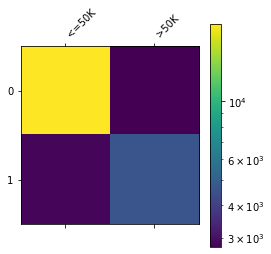

In [85]:
from sklearn.linear_model import LinearRegression

# # Shuffle training set in case model is sensitive to order
# np.random.seed(42)
# shuffle_index = np.random.permutation(len(X_trainTrans))
# X_trainTrans, y_train = X_trainTrans[shuffle_index], y_train[shuffle_index]

# RobustScaled
lr_clf = LinearRegression()
lr_clf.fit(X=X_trainTrans,y=y_train,sample_weight=None)
lr_pred = lr_clf.predict(X_testTrans)
print('lr score for scaling of features:',lr_clf.score(X=X_trainTrans,y=y_train,sample_weight=None))

# No scaling of features
lr_clf.fit(X=X_trainTransNoScale,y=y_train,sample_weight=None)
lr_pred = lr_clf.predict(X_testTransNoScale)
print('lr score for no scaling of features:',lr_clf.score(X=X_trainTransNoScale,y=y_train,sample_weight=None))
# lr score is R^2 value -> Not a good model 


# Using our model create array holding its predicitions
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_trainTrans, y_train, cv=5)

# Construct the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
CM = confusion_matrix(y_train, y_train_pred)

im = plt.matshow(CM,cmap='viridis',norm=LogNorm())
plt.xticks(np.arange(0,2),labels=['<=50K','>50K'],rotation=45,va='bottom',ha='left')
plt.colorbar(im)

TP = CM[1][1]
TN = CM[0][0]
FP = CM[0][1]
FN = CM[1][0]
recall = TP/(TP+FN)
precision = TP/(TP+FP)
accuracy = (TP+TN)/(TP+TN+FP+FN)
F_score = 2*recall*precision/(recall + precision)

## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegressionCV

# RobustScaled features
logr_clf = LogisticRegressionCV(cv=3,random_state=42,solver='lbfgs',max_iter=1000)
logr_clf.fit(X=X_trainTrans,y=y_train,sample_weight=None)
logr_pred = logr_clf.predict(X_testTrans)
print('logr score:',logr_clf.score(X=X_trainTrans,y=y_train,sample_weight=None))

# No scale features
logr_clf.fit(X=X_trainTransNoScale,y=y_train,sample_weight=None)
logr_pred = logr_clf.predict(X_testTransNoScale)
print('logr score:',logr_clf.score(X=X_trainTransNoScale,y=y_train,sample_weight=None))

# lr score is mean accuracy value -> Getting better

logr score: 0.8479824939491396
logr score: 0.7909220516561122


## Stochastic Gradient Descent (SGD)

In [66]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='hinge',max_iter=1000,shuffle=True)#,random_state=42)
sgd_clf.fit(X_trainTrans,y_train,sample_weight=None)
sgd_pred = sgd_clf.predict(X_testTrans)
print('SGD score:',sgd_clf.score(X_testTrans,y_test)) # This is accuracy in getting the label correct


from sklearn.model_selection import cross_val_score
print('\nAverage accuracy after 5-fold cross validation:')
print(cross_val_score(sgd_clf, X_trainTrans, y_train, cv=5,scoring='accuracy')) # Mediocre improvement using linear SVM model



from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_trainTrans, y_train, cv=5)

# Construct the confusion matrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_train, y_train_pred)
print(CM)


SGD score: 0.8130146082337317

Average accuracy after 5-fold cross validation:
[0.79827615 0.80852122 0.81780504 0.81846817 0.78680371]
[[19792  2861]
 [ 2807  4701]]


## Support Vector Machines (SVM)

In [ ]:
from sklearn import svm
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)
print('SVM score:',svm_clf.score(X_test,y_test))